In [69]:
from env import Env
import openai
import spotipy
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler, scale
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import (KNeighborsClassifier, 
                               KNeighborsRegressor)
from spotipy.oauth2 import SpotifyClientCredentials 
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_squared_log_error, 
                             median_absolute_error, 
                             explained_variance_score, 
                             r2_score)

In [2]:
# load API keys from .env file
openai.api_key = Env.OPEN_AI_KEY
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

## Create playlist using ChatGPT
Create seed playlist with ChatGPT for song characteristic analysis.

**\#PromptEngineering \#ChatGPT**

In [3]:
def get_playlist_recommendation(number_of_songs, genre):
    """
    Uses OpenAI's GPT-4 to generate a playlist recommendation based on the number of songs and genre.

    Args: 
        number_of_songs (int): number of songs in the playlist
        genre (str): genre of the playlist

    Returns:
        list: list of songs in the playlist
    """
    response=openai.ChatCompletion.create(
        model='gpt-4',
        messages=[
            {
                'role':'system',
                'content':
                """
                You are a music playlist designer.  You create playlists for people based on different inputs.

                Output all playlists in the following JSON format: 

                {
                    "playlist_name": "<name>",
                    "playlist_description": "<description>",
                    "playlist_tracks": [
                        "<track_name_1>",
                        "<track_name_2>",
                        ...
                    ]
                }

                Replace <track_name_n> with just the name of the song (do not add the artist) that you want in the playlist. 

                If you don't know what to do, type "help". 

                I want you to return in a json format only and not any extra text. 
                

                """
            },
        {
            'role':'user',
            'content':f"Can you create me a {genre} playlist of {number_of_songs} songs"
        }
        ] 
    )
    return json.loads(response.choices[0]['message']['content'])['playlist_tracks']
    

In [4]:
songs=get_playlist_recommendation(10, 'rock')
print(songs)

['Stairway to Heaven', 'Bohemian Rhapsody', 'Hotel California', "Sweet Child O' Mine", 'Smells Like Teen Spirit', 'Comfortably Numb', 'Back In Black', 'Enter Sandman', 'Highway to Hell', 'November Rain']


## Enrich songs with Spotify data
Use the Spotify API to add features to the songs for further analysis.

**\#WebAPI \#DataEnrichment**

In [9]:
def generate_dataframe_of_playlist(number_of_songs, genre):
    

    # extract songs from text response
    songs=get_playlist_recommendation(number_of_songs, genre)

    # filter song attributes from spotify
    filter_song = lambda song: ({
        'id': song['id'],
        'name': song['name'],
        'artist': song['artists'][0]['name'],
        'album': song['album']['name'],
        'length': song['duration_ms'],
        'explicit': song['explicit'],
        'popularity': song['popularity'],
        'type': song['type']
    }) 

    # get the spotify song ids
    spotify_songs = [ 
        filter_song(spotify.search(song)['tracks']['items'][0]) 
        for song in songs 
    ]

    # get the spotify song features
    spotify_songs = [
        {**song, **spotify.audio_features(song['id'])[0]}
        for song in spotify_songs
    ]

    return pd.DataFrame(spotify_songs)

In [49]:
hip_pop_songs=generate_dataframe_of_playlist(100, 'hip hop')

In [50]:
# drop columns that are identifiers and are not needed
hip_pop_songs.info()
hip_pop_songs.drop(['id','name','artist','album', 'type', 'uri', 'track_href', 'analysis_url'], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                101 non-null    object 
 1   name              101 non-null    object 
 2   artist            101 non-null    object 
 3   album             101 non-null    object 
 4   length            101 non-null    int64  
 5   explicit          101 non-null    bool   
 6   popularity        101 non-null    int64  
 7   type              101 non-null    object 
 8   danceability      101 non-null    float64
 9   energy            101 non-null    float64
 10  key               101 non-null    int64  
 11  loudness          101 non-null    float64
 12  mode              101 non-null    int64  
 13  speechiness       101 non-null    float64
 14  acousticness      101 non-null    float64
 15  instrumentalness  101 non-null    float64
 16  liveness          101 non-null    float64
 1

In [51]:
# Create a depedent variable matrix and dependent variable vector
X_all = hip_pop_songs.drop('popularity', axis=1)
y = hip_pop_songs['popularity']

In [52]:
# Use mutual information to select the top 8 features
mi_reg = pd.Series(mutual_info_regression(X_all, y),
                   index=X_all.columns).sort_values(ascending=False)
X = X_all.loc[:, mi_reg.iloc[:8].index]

## Feature distribution

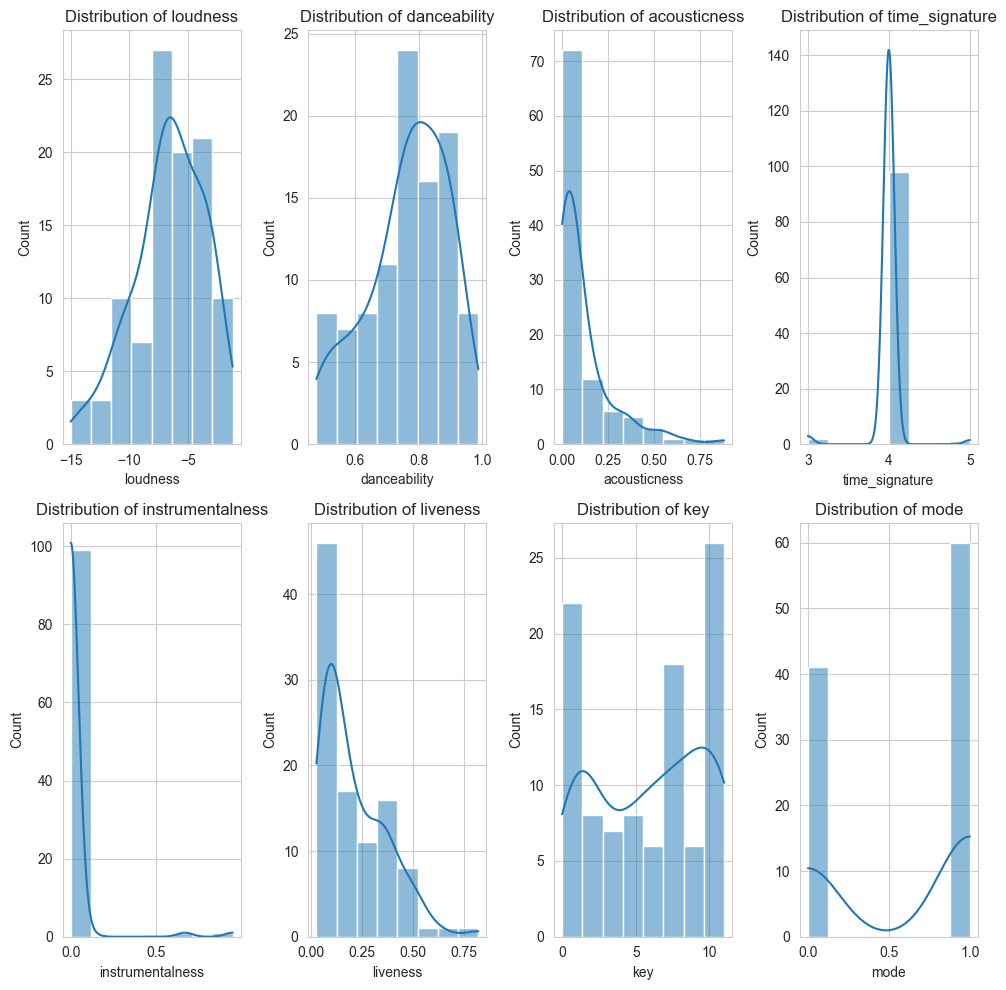

In [54]:
plt.figure(figsize=(10, 10))
for column in X.columns:
    plt.subplot(2,4, list(X.columns).index(column) + 1)
    sns.histplot(X[column],bins=8, kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()


## Bivariate Distribution and Covariance

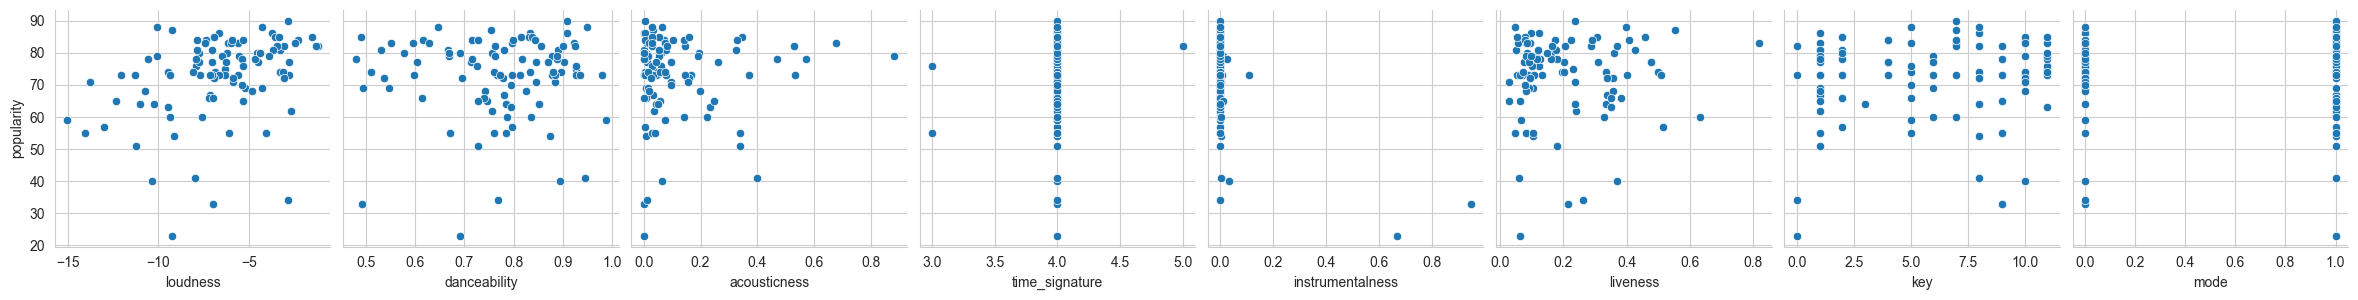

In [55]:
sns.set_style('whitegrid')
g=sns.pairplot(X.assign(popularity=y), y_vars=['popularity'], x_vars=X.columns, height=3)


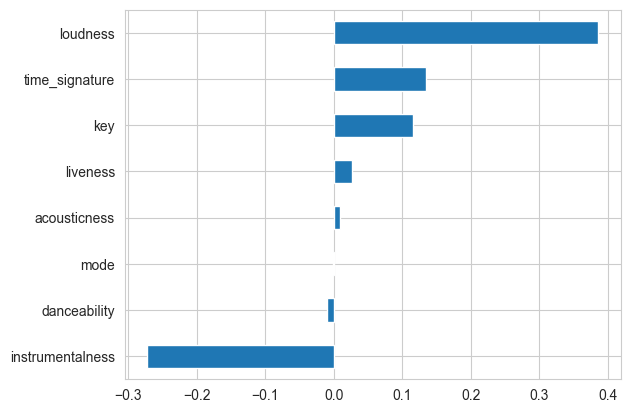

In [59]:
# Create a correlation matrix to see how the features correlate with popularity
correl = X.apply(lambda x: spearmanr(x, y)[0])
correl.sort_values().plot.barh();
X_features=X[['loudness','time_signature','key','liveness','instrumentalness']]

## Build linear regressiion and KNN Regression Models

### Linear Regression Model

In [60]:
## Build a linear regression model to predict popularity
model = LinearRegression()

## Fit the model
model.fit(X_features, y)

## Print the model coefficients
print('Intercept:', model.intercept_)
print('Coefficients:', model.coef_)

Intercept: 49.656836025894904
Coefficients: [  1.27898541   7.51904958   0.39729972   0.07005481 -51.23556831]


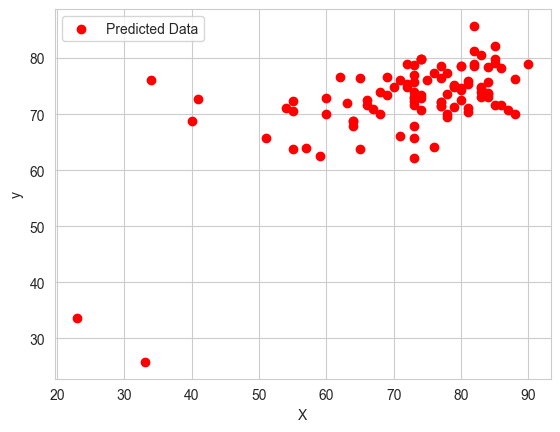

In [63]:
# Predict on the same data
y_pred = model.predict(X_features)

# Plot the predicted data points
plt.scatter(y, y_pred, label="Predicted Data", color="red")

# Add labels and a legend
plt.xlabel("X")
plt.ylabel("y")
plt.legend()

# Show the plot
plt.show()

### Regression Error Metrics

/var/folders/f_/x4nswpgn2sx7wk6xxdw03ps00000gn/T/ipykernel_32635/2906747184.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, ax=axes[1])


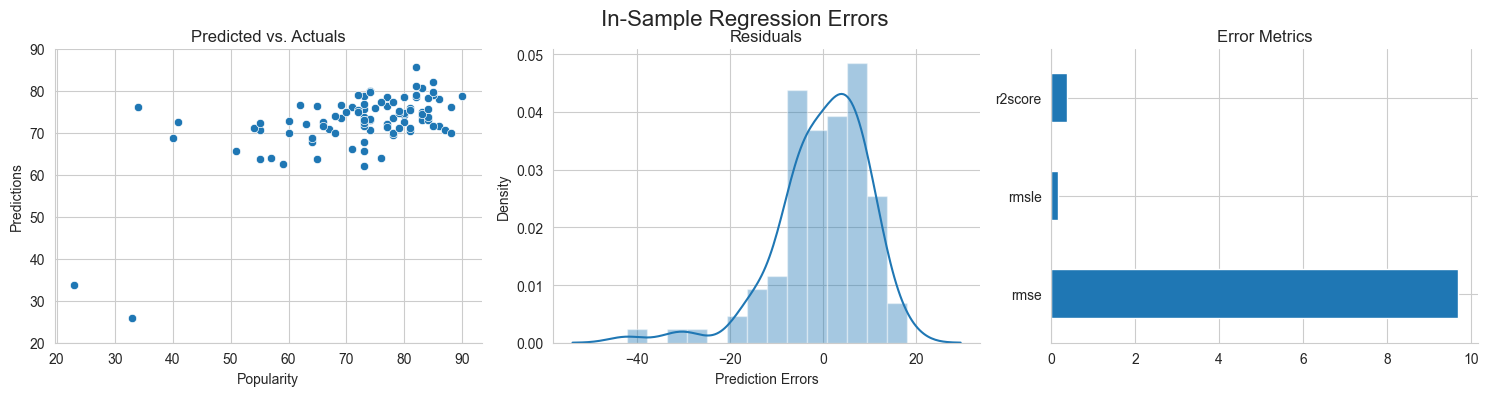

In [67]:
error = (y - y_pred).rename('Prediction Errors')
# Calculate the errors based on multiple metrics
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred)
)

fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Popularity')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(20, 90)
axes[0].set_title('Predicted vs. Actuals')
sns.distplot(error, ax=axes[1])
axes[1].set_title('Residuals')
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')
fig.suptitle('In-Sample Regression Errors', fontsize=16)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.88)

### KNN Model 

In [70]:
# Standardize the features using the StandardScaler to make distance comparisons easier
X_scaled = scale(X_features)

# Fit a KNN model
model_KNN = KNeighborsRegressor()
model_KNN.fit(X=X_scaled, y=y)

y_pred_KNN = model.predict(X_scaled)

/Users/dongfangwang/PycharmProjects/spotify_playlist_analysis/venv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


/var/folders/f_/x4nswpgn2sx7wk6xxdw03ps00000gn/T/ipykernel_32635/1182053440.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error_KNN, ax=axes[1])


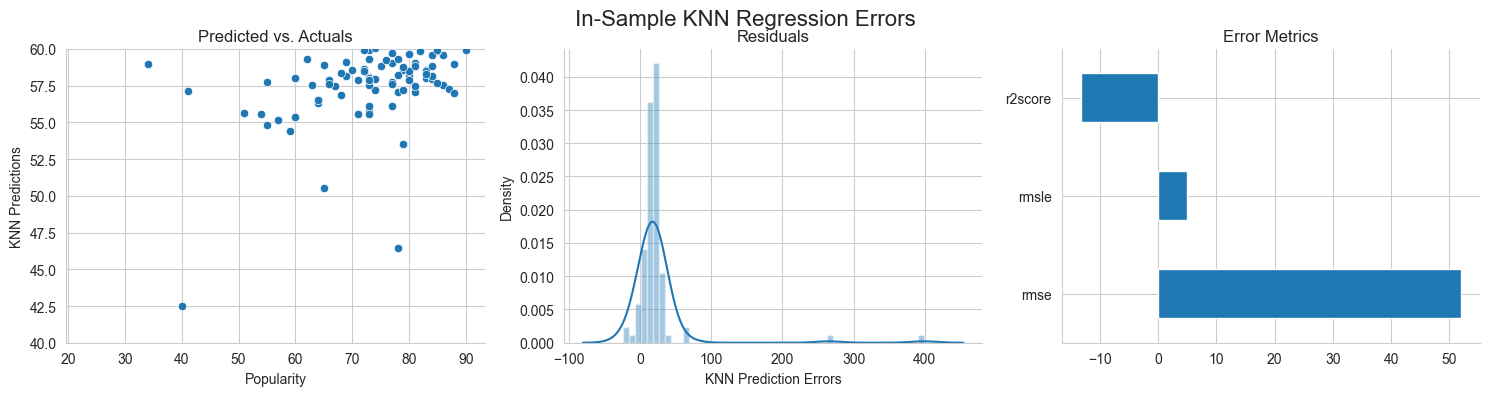

In [74]:
error_KNN = (y - y_pred_KNN).rename('KNN Prediction Errors')

scores_KNN = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred_KNN)),
    rmsle=np.sqrt(mean_absolute_error(y_true=y, y_pred=y_pred_KNN)),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred_KNN)
)
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
sns.scatterplot(x=y, y=y_pred_KNN, ax=axes[0])
axes[0].set_xlabel('Popularity')
axes[0].set_ylabel('KNN Predictions')
axes[0].set_ylim(40,60)
axes[0].set_title('Predicted vs. Actuals')
sns.distplot(error_KNN, ax=axes[1])
axes[1].set_title('Residuals')
pd.Series(scores_KNN).plot.barh(ax=axes[2], title='Error Metrics')
fig.suptitle('In-Sample KNN Regression Errors', fontsize=16)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.88)